# Packages

In [1]:
#basic packages
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#data pre-processing packages
from datetime import datetime


#results and analysis packages
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# data modelling & results
from yellowbrick.regressor import PredictionError, ResidualsPlot
from sklearn.model_selection import train_test_split

#NN
import tensorflow as tf

from tensorflow import keras
from keras.utils.vis_utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

#feature importance
import shap


# Script

## Error computation

In [3]:
#defining the Root Mean Squared Error

def rmse(y_true, y_predicted):
    
    return np.sqrt(mean_squared_error(y_true, y_predicted))

In [4]:
#errors computation

def errors_computation(data):
    
    df=pd.DataFrame()
    #df.at['RMSE (as root mean)', 'Wind']= round(rmse(data['Target'], data['WS_pred']), 3)
    df.at['MAE (in avg)', 'Wind']= round(mae(data['Target'], data['WS_pred']), 3)
    df.at['MAPE (%)', 'Wind']= round(mape(data['Target'], data['WS_pred'])*100, 3)
    
    #df.at['RMSE (as root mean)', 'Power']= round(rmse(data['P'], data['P_pred']), 3)
    df.at['MAE (in avg)', 'Power']= round(mae(data['P'], data['P_pred']), 3)
    df.at['MAPE (%)', 'Power']= round(mape(data['P'], data['P_pred'])*100, 3)
    
    
    print('Wind RMSE: ', round(rmse(data['Target'], data['WS_pred']), 3), 'm/s as root mean')
    print('Wind MAE: ', round(mae(data['Target'], data['WS_pred']), 3), 'm/s in avg')
    print('Wind MAPE: ', round(mape(data['Target'], data['WS_pred'])*100, 3), '%')
    
    print('Power RMSE: ', round(rmse(data['P'], data['P_pred']), 3), 'kW as root mean')
    print('Power MAE: ', round(mae(data['P'], data['P_pred']), 3), 'kW in avg')
    print('Power MAPE: ', round(mape(data['P'], data['P_pred'])*100, 3), '%')
    
    return df

In [5]:
def error_plot(data, title):
    
    #title is expected to be an str
    #WS_pred and Target should be the variables names

    #plotting the reference
    plt.figure(figsize=(12,8))
    plt.plot([-1,17.5],[-1,17.5], 'green', linewidth=4, alpha=.12)
    plt.plot(data['WS_pred'], data['Target'], marker='o', ls='', label='Regression', markersize=5, alpha=.1)


    plt.legend()

    ax=plt.gca()
    ax.set(xlabel='y predicted', ylabel='y actual');
    ax.set_title(title)
    ax.set_ylim(ymin=4, ymax=17.5)
    ax.set_xlim(xmin=4, xmax=17.5)
    
    return print('')

In [6]:
def powercurve_computation(data, power_curve):
    
    from scipy import interpolate
    
    #this function computes the power at a observation given the information at a observation:
    # the WS (in m/s) at the wind turbine location and at the hub height (Target)
    # the power curve of the wind turbine in an xslx
    
    
    x=power_curve['Wind Speed [m/s]']
    y=power_curve['Warranted Power Curve [kW]']
    x_new=data['Target']
    
    f = interpolate.interp1d(x, y)
    #, kind='linear'
    data['P']=f(x_new)
    
    if 'WS_pred' in data.keys():
        x_new2=data['WS_pred']
        data['P_pred']=f(x_new2)
    
    print('power curve computation performed')
    
    return data

In [7]:
def control_power_computation (data_test, data_train, power_curve):
    
    results_test=pd.DataFrame()
    results_train=pd.DataFrame()
    
    
    results_test=powercurve_computation(data_test, power_curve)
    results_train=powercurve_computation(data_train, power_curve)

    return results_test, results_train

In [8]:
def compute_results(data_test, data_train, power_curve, plot_error):
    
    #this function computes and plots the results of a modelling:

    results_test, results_train=control_power_computation (data_test, data_train, power_curve)
    
    
    print('Modelling errors for training set:')
    errors_computation(results_train)
    print('')
    print('Modelling errors for test set:')
    errors_computation(results_test)
    
    if plot_error:
        print('')
        error_plot(results_test, 'Error plot for test set wind speed')

    print('')
    return print('Showing the results of the modelling: ')

## Data uploading

In [9]:
def uploading_csv(file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function uploads and formats csv/txt/xlsx datasets into DataFrame
    
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data1 = pd.read_csv(data_path)

    
    # We will save the WD_bin as the index
    
    return data1

In [10]:
#this function saves a data csv

def save (data, file_folder,file_name):
    
    #file folder required
    #file name required
    #file is expected to be saved in the data root: r'C:\Users\irgaa\Irma\Data'
    #this function saves a csv/txt/xlsx into Irma's folder
    #the saved file will keep the columns names but not the index
    
    data_root=r'C:\Users\irgaa\Irma\Data'
    data_folder=str(file_folder)
    data_file=str(file_name)
    
    data_path=data_root+data_folder+data_file
    
    data.to_csv (data_path, index = False, header=True)
    
    
    return print('file', data_file, 'saved in', data_folder, 'folder')

## Data selection

In [11]:
def data_selection(X_train, X_test, inputs):
    
    #this function returns the columns of the training and test sets in the inputs list
    
    X_train1 = pd.DataFrame()
    X_test1 = pd.DataFrame()
    
    
    X_train1 = X_train[inputs]
    X_test1 = X_test[inputs]

    
    return X_train1,X_test1

In [12]:
def data_drop(X_train, X_test, list_2drop):
    
    #this function returns the columns of the training and test sets in the inputs list

    X_train1 = X_train.drop(columns=list_2drop)
    X_test1 = X_test.drop(columns=list_2drop)

    
    
    return X_train1,X_test1

## Modelling

### Model building

In [13]:
def build_model (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        
        if regularization=='l2':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                            kernel_regularizer=keras.regularizers.l2(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                           kernel_regularizer=keras.regularizers.l2(0.01)))  
        elif regularization=='l1':
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal',
                                             kernel_regularizer=keras.regularizers.l1(0.01)))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal',
                                            kernel_regularizer=keras.regularizers.l1(0.01))) 
        else:
            if activation=='relu':
                model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
            elif activation=='elu':
                model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
            elif activation=='selu':
                model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
    
    #dropout only considered in the last layer
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

In [14]:
def build_model_old (n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8],
                 activation='relu', optimizer='Adam', regularization=None, Leaky=False):
    
    #this function build model is created only for building the NN
    #it will always initialize the weights using the strategy 'He normal' unless activation function 'selu' is selected
    
    
    if activation!='relu':
        Leaky==False
    
    
    #we create a sequential model:
    model=keras.models.Sequential()
    
    #we add the input layer with n_neurons=n_features (shape of X_train)
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    #we add a hidden layer for each n_hidden with ReLU as activation function
    #this code considers the same n_neurons for each hidden layer
    for layer in range(n_hidden):
        if activation=='relu':
            model.add(keras.layers.Dense(n_neurons, activation='relu', kernel_initializer='he_normal'))
        elif activation=='elu':
            model.add(keras.layers.Dense(n_neurons, activation='elu', kernel_initializer='he_normal'))
        elif activation=='selu':
            model.add(keras.layers.Dense(n_neurons, activation='selu', kernel_initializer='lecun_normal'))
        if Leaky:
            model.add(keras.layers.LeakyReLU(alpha=0.2))
            
    if regularization=='Dropout':
        model.add(keras.layers.Dropout(rate=0.2))
        
    #we add the output layer with one neuron (we only want to predict 1 target)
    model.add(keras.layers.Dense(1))
    
    #we choose our optimizer and build it:
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    elif optimizer=='Momentum':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9)
    elif optimizer=='Nesterov':
        optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
    elif optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate, rho=0.9)
    elif optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
    elif optimizer=='Nadam':
        optimizer=keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    
    #we compile our model with the selected optimizer and set the objective function loss='mse'
    model.compile(loss='mse', optimizer=optimizer)
    
    return model
    

### Modelling NN

In [15]:
def modelling_NN (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    if regularization=='Early Stopping':
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
#     mse_test=model.evaluate(X_test, y_test)
#     rmse_test=np.sqrt(mse_test)
#     print('RMSE for test', rmse_test)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

In [16]:
def modelling_NN_ES (X, X_test, y, y_test, power_curve,  parameters, plot_error, plot):
    
    #creating the model
    
    n_hidden=parameters['n_hidden']
    n_neurons=parameters['n_neurons']
    learning_rate=parameters['learning_rate']
    input_shape=X.shape[1:]
    activation=parameters['activation']
    optimizer=parameters['optimizer']
    regularization=parameters['regularization']
    Leaky=parameters['Leaky']
    
    model =build_model(n_hidden, n_neurons, learning_rate, input_shape,
                 activation, optimizer, regularization, Leaky)
 
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    

    model.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
#     if plot:
#         loss_epochs_plot (history)
        
    
    #model predicting
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
#     mse_test=model.evaluate(X_test, y_test)
#     rmse_test=np.sqrt(mse_test)
#     print('RMSE for test', rmse_test)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('NN modelling performed')
    
    return model

### Random Search NN

In [17]:
def RandomSearch_NN(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #counting the runing time
    start_time = time.time()
    
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    regularization=param_distribs['regularization']
    
    if regularization=='Early Stopping':
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    else:
        rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid))
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('')
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model
    

In [18]:
def RandomSearch_NN_ES(X, X_test, y, y_test, power_curve, param_distribs, plot_error):
    
    #creating the model
    input_shape=X.shape[1:]
    param_distribs['input_shape']=input_shape
    keras_reg =keras.wrappers.scikit_learn.KerasRegressor(build_model, verbose=0)
    
    #Random Search CV
    rnd_search_cv=RandomizedSearchCV(keras_reg, param_distribs, n_iter=20, cv=3)
    
    #model fitting
    X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=42)
    
    rnd_search_cv.fit(X_train, y_train, epochs=100,
                      validation_data=(X_valid, y_valid),
                      callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    
    #model predicting
    
    model=rnd_search_cv.best_estimator_.model
    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])
    
    print('')
    print('Best parameters :')
    print(rnd_search_cv.best_params_)
    print('')

    #computing the results
    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y['Target']
    
    compute_results(data_test, data_train, power_curve, plot_error)
    print('RandomSearch_ NN performed')
    
    return model

### Loss plot

In [19]:
def loss_epochs_plot (history):
    
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.show
    
    return print('Loss vs. epochs plot performed')
    
    

### Model Testing

In [20]:
def model_testing (X_train, X_test, y_train, y_test, power_curve, model, plot_error):

    

    y_pred_test=model.predict(X_test)
    y_pred_train=model.predict(X_train)
    
    test=pd.DataFrame(y_pred_test, columns = ['test'])
    train=pd.DataFrame(y_pred_train, columns = ['train'])


    data_test = pd.DataFrame()
    data_train = pd.DataFrame()
    
    data_test['WS_pred']=test['test']
    data_test['Target']=y_test['Target']
    data_train['WS_pred']=train['train']
    data_train['Target']=y_train['Target']
    
    plot_model(model, show_shapes=True, show_layer_names=True)
    
    
    compute_results(data_test, data_train, power_curve, plot_error)
    
    WS_pred=data_test['WS_pred']
    print('NN results performed')
    
    return WS_pred

### Feature importance

In [21]:
def feature_importance (X_train, X_test, model):
    
    X_t, X_f, y_t, y_f = train_test_split(X_train,y_train, test_size=0.02, random_state=12)
    
    background = X_f.copy()
    
    explainer = shap.KernelExplainer(model.predict,background)
    shap_values = explainer.shap_values(X_test,nsamples=100)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    print('Feature importance through SHAP values performed')
    

    return shap_values

In [22]:
def transform_shap (shap_values, X_test):

    v=np.array(shap_values)
    d=v.reshape(X_test.shape)
    shap_v=pd.DataFrame(d)
    
    feature_list=X_test.columns
    shap_v.columns=feature_list
    shap_v=shap_v.abs()
    k=pd.DataFrame(shap_v.mean()).reset_index()
    k.columns=['variables','SHAP_abs']
    k.sort_values(by='variables')
    
    return k
    

# Data analysis

## Dataset1- WTG14

In [23]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset1-Normal_Site','\X_train14.csv')
X_test= uploading_csv('\Dataset1-Normal_Site','\X_test14.csv')
y_train= uploading_csv('\Dataset1-Normal_Site','\y_train14.csv')
y_test= uploading_csv('\Dataset1-Normal_Site','\y_test14.csv')

X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [24]:
y_test.keys()

Index(['Target'], dtype='object')

In [25]:
X_test.head()

,T2,RH2,T1,RH1,PR1,AD1,PR2,AD2,Rain,WS1,...,WD4,WSHor,WDHor,WSVer,WDVer,TI,WSH,WD_bin,tod,WVeer
0,0.317472,0.636355,0.340125,0.619360,0.030801,0.484003,0.035362,0.498223,0.0,0.389831,...,0.534138,0.400754,0.715190,0.554293,0.492834,0.401251,0.316505,0.8,0.083916,0.655683
1,0.089466,0.791074,0.101354,0.809109,0.737198,0.870019,0.765898,0.881242,0.0,0.490117,...,0.722105,0.494487,0.804378,0.562792,0.485612,0.198639,0.310161,0.8,0.223776,0.497300
2,0.556667,0.587084,0.572726,0.600075,0.736106,0.420494,0.744780,0.421262,0.0,0.510292,...,0.664341,0.513474,0.714333,0.550759,0.500389,0.456993,0.286590,0.8,0.860140,0.503073
3,0.135653,0.864725,0.132842,0.884058,0.205901,0.721012,0.203882,0.712520,0.0,0.219129,...,0.748591,0.227576,0.988457,0.416675,0.386403,0.425696,0.186749,1.0,0.377622,0.597797
4,0.369032,0.359721,0.386156,0.351401,0.707787,0.587475,0.725928,0.595351,0.0,0.478077,...,0.601639,0.486262,0.644355,0.418298,0.416080,0.255090,0.377160,0.6,0.811189,0.520563


In [26]:
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

### RandomSearch

In [28]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [29]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-3.98551663 -0.14395947 -0.32253063         nan -0.15152594 -0.22173306
 -0.66491832 -0.22325017 -0.15306451 -0.21406976 -0.1724265  -1.19458397
 -0.2154945  -0.16120041 -0.18491064 -0.18464693 -0.1743432  -0.2270332
 -0.17390798 -0.20609822]



Best parameters :
{'regularization': None, 'optimizer': 'Adam', 'n_neurons': 90, 'n_hidden': 3, 'learning_rate': 0.005, 'input_shape': 24, 'activation': 'selu', 'Leaky': False}

--- 8.844393825531006 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.364 m/s as root mean
Wind MAE:  0.281 m/s in avg
Wind MAPE:  3.265 %
Power RMSE:  163.174 kW as root mean
Power MAE:  103.878 kW in avg
Power MAPE:  7.198 %

Modelling errors for test set:
Wind RMSE:  0.405 m/s as root mean
Wind MAE:  0.31 m/s in avg
Wind MAPE:  3.671 %
Power RMSE:  187.912 kW as root mean
Power MAE:  118.157 kW in avg
Power MAPE:  8.383 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [49]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [50]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': None, 'optimizer': 'Nesterov', 'n_neurons': 80, 'n_hidden': 1, 'learning_rate': 0.005, 'input_shape': 25, 'activation': 'relu', 'Leaky': False}

--- 8.028279749552409 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.355 m/s as root mean
Wind MAE:  0.269 m/s in avg
Wind MAPE:  3.166 %
Power RMSE:  157.018 kW as root mean
Power MAE:  97.824 kW in avg
Power MAPE:  7.235 %

Modelling errors for test set:
Wind RMSE:  0.38 m/s as root mean
Wind MAE:  0.287 m/s in avg
Wind MAPE:  3.395 %
Power RMSE:  170.91 kW as root mean
Power MAE:  108.358 kW in avg
Power MAPE:  7.832 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [55]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout'],
    'Leaky':[True, False],
}

In [56]:
model= RandomSearch_NN_ES(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': None, 'optimizer': 'Nesterov', 'n_neurons': 80, 'n_hidden': 1, 'learning_rate': 0.01, 'input_shape': 25, 'activation': 'relu', 'Leaky': False}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.384 m/s as root mean
Wind MAE:  0.293 m/s in avg
Wind MAPE:  3.396 %
Power RMSE:  165.7 kW as root mean
Power MAE:  104.965 kW in avg
Power MAPE:  7.47 %

Modelling errors for test set:
Wind RMSE:  0.395 m/s as root mean
Wind MAE:  0.298 m/s in avg
Wind MAPE:  3.501 %
Power RMSE:  175.827 kW as root mean
Power MAE:  112.186 kW in avg
Power MAPE:  7.905 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [78]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':['iRMA', 'Dropout'],
    'Leaky':[True, False],
}

In [79]:
model= RandomSearch_NN_ES(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nesterov', 'n_neurons': 100, 'n_hidden': 2, 'learning_rate': 0.005, 'input_shape': 25, 'activation': 'relu', 'Leaky': False}

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.432 m/s as root mean
Wind MAE:  0.326 m/s in avg
Wind MAPE:  3.827 %
Power RMSE:  183.918 kW as root mean
Power MAE:  114.768 kW in avg
Power MAPE:  8.683 %

Modelling errors for test set:
Wind RMSE:  0.44 m/s as root mean
Wind MAE:  0.331 m/s in avg
Wind MAPE:  3.9 %
Power RMSE:  190.303 kW as root mean
Power MAE:  120.777 kW in avg
Power MAPE:  8.91 %

Showing the results of the modelling: 
RandomSearch_ NN performed


In [71]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam', 'RMSProp'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [73]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20


Best parameters :
{'regularization': 'Early Stopping', 'optimizer': 'Adam', 'n_neurons': 80, 'n_hidden': 2, 'learning_rate': 0.003, 'input_shape': 25, 'activation': 'elu', 'Leaky': True}

--- 8.597513794898987 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.416 m/s as root mean
Wind MAE:  0.339 m/s in avg
Wind MAPE:  3.78 %
Power RMSE:  183.277 kW as root mean
Power MAE:  122.235 kW in avg
Power MAPE:  7.603 %

Modelling errors for test set:
Wind RMSE:  0.446 m/s as root mean
Wind MAE:  0.357 m/s in avg
Wind MAPE:  4.076 %
Power RMSE:  198.688 kW as root mean
Power MAE:  132.408 kW in avg
Power MAPE:  8.569 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [36]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [37]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
77/77 [==============================] - 0s 4ms/step - loss: 11.5409 - val_loss: 1.0413
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.4488 - val_loss: 0.3178
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2776 - val_loss: 0.2382
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2392 - val_loss: 0.2300
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2258 - val_loss: 0.2252
Epoch 6/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2290 - val_loss: 0.2034
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2096 - val_loss: 0.2152
Epoch 8/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2052 - val_loss: 0.2174
Epoch 9/100
77/77 [==============================] - 0s 3ms/step - loss: 0.1941 - val_loss: 0.1959
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1882 - val_loss: 0.2341
Epoch 11

77/77 [==============================] - 0s 3ms/step - loss: 0.1207 - val_loss: 0.1341
Epoch 84/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1197 - val_loss: 0.1290
Epoch 85/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1192 - val_loss: 0.1131
Epoch 86/100
77/77 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1259
Epoch 87/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1148 - val_loss: 0.1198
Epoch 88/100
77/77 [==============================] - 0s 5ms/step - loss: 0.1117 - val_loss: 0.1175
Epoch 89/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1109 - val_loss: 0.1111
Epoch 90/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1153 - val_loss: 0.1207
Epoch 91/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1160 - val_loss: 0.1364
Epoch 92/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1125 - val_loss: 0.1151
Epoch 93/100


In [51]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [52]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
77/77 [==============================] - 0s 4ms/step - loss: 19.4191 - val_loss: 1.6904
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.5838 - val_loss: 0.3369
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2454 - val_loss: 0.2113
Epoch 4/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2232 - val_loss: 0.2005
Epoch 5/100
77/77 [==============================] - 0s 2ms/step - loss: 0.2049 - val_loss: 0.2050
Epoch 6/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1960 - val_loss: 0.1898
Epoch 7/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1891 - val_loss: 0.2013
Epoch 8/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1864 - val_loss: 0.1858
Epoch 9/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1828 - val_loss: 0.2010
Epoch 10/100
77/77 [==============================] - 0s 2ms/step - loss: 0.1833 - val_loss: 0.1736
Epoch 11

77/77 [==============================] - 0s 4ms/step - loss: 0.1081 - val_loss: 0.1107
Epoch 84/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1094 - val_loss: 0.2276
Epoch 85/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1164 - val_loss: 0.1118
Epoch 86/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1177 - val_loss: 0.1113
Epoch 87/100
77/77 [==============================] - 0s 3ms/step - loss: 0.1084 - val_loss: 0.1191
Epoch 88/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1148 - val_loss: 0.1183
Epoch 89/100
77/77 [==============================] - 0s 6ms/step - loss: 0.1118 - val_loss: 0.1116
Epoch 90/100
77/77 [==============================] - 0s 5ms/step - loss: 0.1193 - val_loss: 0.1457
Epoch 91/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1043 - val_loss: 0.1148
Epoch 92/100
77/77 [==============================] - 0s 5ms/step - loss: 0.1153 - val_loss: 0.1142
Epoch 93/100


In [71]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [72]:
model = modelling_NN_ES (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
77/77 [==============================] - 0s 5ms/step - loss: 11.1970 - val_loss: 0.5620
Epoch 2/100
77/77 [==============================] - 0s 2ms/step - loss: 0.3371 - val_loss: 0.2971
Epoch 3/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2650 - val_loss: 0.2868
Epoch 4/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2347 - val_loss: 0.2271
Epoch 5/100
77/77 [==============================] - 0s 3ms/step - loss: 0.2124 - val_loss: 0.2134
Epoch 6/100
77/77 [==============================] - ETA: 0s - loss: 0.2031- ETA: 0s - loss: 0.20 - 0s 2ms/step - loss: 0.2025 - val_loss: 0.1901
Epoch 7/100
77/77 [==============================] - 0s 3ms/step - loss: 0.1990 - val_loss: 0.2390
Epoch 8/100
77/77 [==============================] - 0s 4ms/step - loss: 0.1977 - val_loss: 0.1808
Epoch 9/100
77/77 [==============================] - 1s 9ms/step - loss: 0.1975 - val_loss: 0.3261
Epoch 10/100
77/77 [==============================] - 1s 7ms/

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE power: 7.32 %

In [38]:
model.save('WTG14_ANN1.h5')

MAPE power: xx %

In [44]:
model.save('WTG14_Axx.h5')

### Model testing

In [27]:
model=keras.models.load_model('WTG14_ANN1.h5')

In [28]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.323 m/s as root mean
Wind MAE:  0.249 m/s in avg
Wind MAPE:  2.877 %
Power RMSE:  146.898 kW as root mean
Power MAE:  92.022 kW in avg
Power MAPE:  6.187 %

Modelling errors for test set:
Wind RMSE:  0.363 m/s as root mean
Wind MAE:  0.277 m/s in avg
Wind MAPE:  3.262 %
Power RMSE:  167.626 kW as root mean
Power MAE:  106.493 kW in avg
Power MAPE:  7.32 %

Showing the results of the modelling: 
NN results performed


In [29]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG14.csv')

file ANN_WTG14.csv saved in \Results_ folder


### Feature importance

  0%|          | 0/1306 [00:00<?, ?it/s]

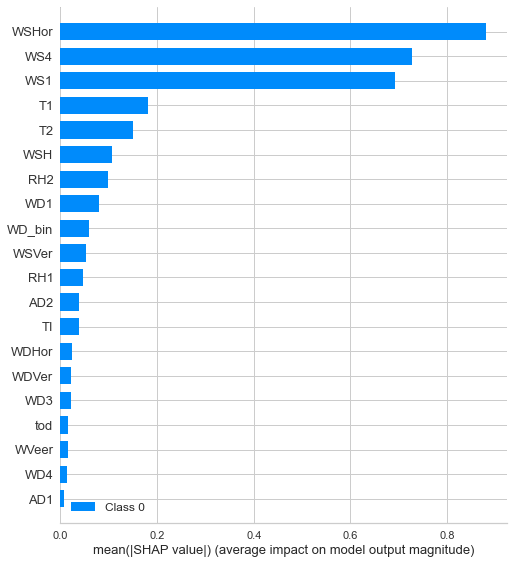

Feature importance through SHAP values performed


In [75]:
shap_values=feature_importance (X_train, X_test, model)

In [76]:
k=transform_shap (shap_values, X_test)

In [77]:
X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [78]:
k

,variables,SHAP_abs
0,T2,0.149231
1,RH2,0.097610
2,T1,0.181885
3,RH1,0.046647
4,PR1,0.003911
5,AD1,0.007266
6,PR2,0.005107
7,AD2,0.039358
8,Rain,0.000787
9,WS1,0.692661


In [102]:
v=np.array(shap_values)

In [106]:
d=v.reshape(X_test.shape)

In [104]:
d


array([[[-0.05968182,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.09837991],
        [ 0.        ,  0.        ,  0.        , ...,  0.14081973,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.21122331,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.20668495, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.19280321,
          0.        ,  0.        ]]])

In [107]:
e=pd.DataFrame(d)

In [108]:
e

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.059682,0.000000,0.000000,-0.089369,0.000000,-0.296950,0.000000,0.273281,-0.095848,0.0,...,0.000000,-0.272807,0.000000,0.000000,0.000000,0.126148,-0.048960,0.000000,0.000000,-0.09838
1,0.000000,0.000000,0.000000,-0.311346,-0.074599,0.000000,0.000000,0.000000,0.449604,0.0,...,-0.146963,0.000000,0.182592,-0.166558,0.000000,0.000000,0.000000,0.140820,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.200254,0.000000,0.000000,0.000000,0.000000,-0.226631,0.0,...,-0.144254,0.227084,0.000000,-0.088230,0.062891,0.252543,-0.145355,0.211223,0.000000,0.00000
3,0.000000,-0.030068,0.000000,-0.047704,0.000000,-0.178866,0.000000,0.000000,0.000000,0.0,...,-0.209635,-0.749193,0.000000,0.000000,0.000000,0.000000,-0.253064,0.000000,-0.098368,0.00000
4,0.000000,0.000000,-0.149584,0.000000,0.128799,0.000000,0.014291,0.000000,0.000000,0.0,...,0.000000,0.106385,0.028634,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301,0.000000,0.000000,0.000000,-0.175049,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-0.334342,0.465777,0.183371,0.000000,0.000000,0.000000,0.000000,0.118584,0.000000,0.00000
1302,0.000000,0.000000,0.065435,0.000000,0.000000,0.000000,0.000000,0.112363,0.000000,0.0,...,0.000000,0.926576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1303,0.000000,0.000000,-0.206685,0.000000,0.000000,0.000000,-0.199461,0.000000,-0.826420,0.0,...,0.000000,-0.968406,0.000000,0.000000,0.000000,0.000000,-0.190115,0.000000,0.000000,0.00000
1304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,-0.701422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [98]:
np.array(shap_values)

array([[[-0.05968182,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.09837991],
        [ 0.        ,  0.        ,  0.        , ...,  0.14081973,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.21122331,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        , -0.20668495, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.19280321,
          0.        ,  0.        ]]])

## Dataset1- WTG15

In [30]:
#upload the dataset with file_folder, file_name
# data_up= uploading_csv('\Dataset1-Normal_Site','\data_comp14.csv')
X_train= uploading_csv('\Dataset1-Normal_Site','\X_train15.csv')
X_test= uploading_csv('\Dataset1-Normal_Site','\X_test15.csv')
y_train= uploading_csv('\Dataset1-Normal_Site','\y_train15.csv')
y_test= uploading_csv('\Dataset1-Normal_Site','\y_test15.csv')

X_test.keys()

Index(['T2', 'RH2', 'T1', 'RH1', 'PR1', 'AD1', 'PR2', 'AD2', 'Rain', 'WS1',
       'WS3', 'WS4', 'WD1', 'WD3', 'WD4', 'WSHor', 'WDHor', 'WSVer', 'WDVer',
       'TI', 'WSH', 'WD_bin', 'tod', 'WVeer'],
      dtype='object')

In [31]:
y_test.keys()

Index(['Target'], dtype='object')

In [32]:
PC= uploading_csv('\Dataset1-Normal_Site','\PC_1.15kgm-3.csv')

### Random Search

In [56]:
param_distribs={
    'n_hidden':[0, 1, 2, 3],
    'n_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.005, 0.01, 0.03],
    'activation':['relu', 'elu', 'selu'],
    'optimizer':['Adam', 'Nesterov', 'Momentum', 'Nadam'],
    'regularization':[None, 'Dropout', 'Early Stopping'],
    'Leaky':[True, False],
}

In [57]:
model= RandomSearch_NN(X_train, X_test, y_train, y_test, PC, param_distribs, plot_error=False)
#iter=20

One or more of the test scores are non-finite: [-0.37749771         nan -2.91082818 -0.77679342 -0.38081569 -0.37757527
 -0.49022656 -7.67139975 -2.93948711 -3.72904217 -0.35976648 -0.39512298
 -0.41844858 -0.3662878  -2.82715352 -0.37654306 -0.42046572 -8.01278019
 -0.37031429 -0.39685519]



Best parameters :
{'regularization': 'Dropout', 'optimizer': 'Nesterov', 'n_neurons': 40, 'n_hidden': 3, 'learning_rate': 0.001, 'input_shape': 24, 'activation': 'relu', 'Leaky': False}

--- 10.393785885969798 minutes ---

power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.537 m/s as root mean
Wind MAE:  0.416 m/s in avg
Wind MAPE:  5.029 %
Power RMSE:  250.097 kW as root mean
Power MAE:  163.428 kW in avg
Power MAPE:  11.933 %

Modelling errors for test set:
Wind RMSE:  0.558 m/s as root mean
Wind MAE:  0.434 m/s in avg
Wind MAPE:  5.303 %
Power RMSE:  263.441 kW as root mean
Power MAE:  174.427 kW in avg
Power MAPE:  12.945 %

Showing the results of the modelling: 
RandomSearch_ NN performed


### Manual modelling

In [58]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'relu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [59]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 0s 4ms/step - loss: 13.1988 - val_loss: 0.6998
Epoch 2/100
110/110 [==============================] - 0s 3ms/step - loss: 0.5419 - val_loss: 0.4125
Epoch 3/100
110/110 [==============================] - 0s 3ms/step - loss: 0.4115 - val_loss: 0.4375
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3914 - val_loss: 0.3565
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.3738 - val_loss: 0.3514
Epoch 6/100
110/110 [==============================] - 0s 3ms/step - loss: 0.3665 - val_loss: 0.3360
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3492 - val_loss: 0.3273
Epoch 8/100
110/110 [==============================] - 0s 3ms/step - loss: 0.3543 - val_loss: 0.3284
Epoch 9/100
110/110 [==============================] - 0s 3ms/step - loss: 0.3498 - val_loss: 0.3198
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3426 - val_l

Epoch 81/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2408 - val_loss: 0.4155
Epoch 82/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2437 - val_loss: 0.2767
Epoch 83/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2450 - val_loss: 0.2584
Epoch 84/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2347 - val_loss: 0.2684
Epoch 85/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2333 - val_loss: 0.2841
Epoch 86/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2362 - val_loss: 0.2593
Epoch 87/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2413 - val_loss: 0.2665
Epoch 88/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2450 - val_loss: 0.2523
Epoch 89/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2411 - val_loss: 0.2741
Epoch 90/100
110/110 [==============================] - 0s 2ms/step - loss: 0.2352

In [61]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'selu',
    'optimizer':'Nesterov',
    'regularization':None,
    'Leaky':True
}

In [62]:
model = modelling_NN (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 3.8616 - val_loss: 0.4515
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4457 - val_loss: 0.4422
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4102 - val_loss: 0.3656
Epoch 4/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3905 - val_loss: 0.3917
Epoch 5/100
110/110 [==============================] - 0s 3ms/step - loss: 0.3883 - val_loss: 0.3593
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3809 - val_loss: 0.3549
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: 0.3745 - val_loss: 0.3497
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3700 - val_loss: 0.4512
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3655 - val_loss: 0.3421
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3661 - val_lo

In [63]:
parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

In [64]:
model = modelling_NN_ES (X_train, X_test, y_train, y_test, PC, parameters, plot_error=False, plot=True)

Epoch 1/100
110/110 [==============================] - 0s 3ms/step - loss: 7.9682 - val_loss: 0.4961
Epoch 2/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4697 - val_loss: 0.4083
Epoch 3/100
110/110 [==============================] - 0s 2ms/step - loss: 0.4160 - val_loss: 0.3744
Epoch 4/100
110/110 [==============================] - 0s 4ms/step - loss: 0.3865 - val_loss: 0.3681
Epoch 5/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3740 - val_loss: 0.3525
Epoch 6/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3648 - val_loss: 0.3524
Epoch 7/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3562 - val_loss: 0.3667
Epoch 8/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3658 - val_loss: 0.3199
Epoch 9/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3539 - val_loss: 0.3255
Epoch 10/100
110/110 [==============================] - 0s 2ms/step - loss: 0.3378 - val_lo

### Model saving

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'relu',
    'optimizer':'Adam',
    'regularization':None,
    'Leaky':True
}

MAPE power: 12.199%

In [60]:
model.save('WTG15_ANN1.h5')

parameters={
    'n_hidden':3,
    'n_neurons': 80,
    'learning_rate':0.001,
    'activation':'elu',
    'optimizer':'Adam',
    'regularization':'Early Stopping,
    'Leaky':True
}

MAPE power: 11.971%

In [65]:
model.save('WTG15_ANN2.h5')

### Model testing

In [33]:
model=keras.models.load_model('WTG15_ANN2.h5')

In [35]:
WS_pred=model_testing (X_train, X_test, y_train, y_test, PC, model, plot_error=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
power curve computation performed
power curve computation performed
Modelling errors for training set:
Wind RMSE:  0.468 m/s as root mean
Wind MAE:  0.357 m/s in avg
Wind MAPE:  4.361 %
Power RMSE:  217.615 kW as root mean
Power MAE:  139.753 kW in avg
Power MAPE:  10.592 %

Modelling errors for test set:
Wind RMSE:  0.509 m/s as root mean
Wind MAE:  0.388 m/s in avg
Wind MAPE:  4.791 %
Power RMSE:  238.634 kW as root mean
Power MAE:  154.189 kW in avg
Power MAPE:  11.971 %

Showing the results of the modelling: 
NN results performed


In [36]:
WS_pred=pd.DataFrame(WS_pred)
save(WS_pred,'\Results_','ANN_WTG15.csv')

file ANN_WTG15.csv saved in \Results_ folder


### Feature importance

  0%|          | 0/1880 [00:00<?, ?it/s]

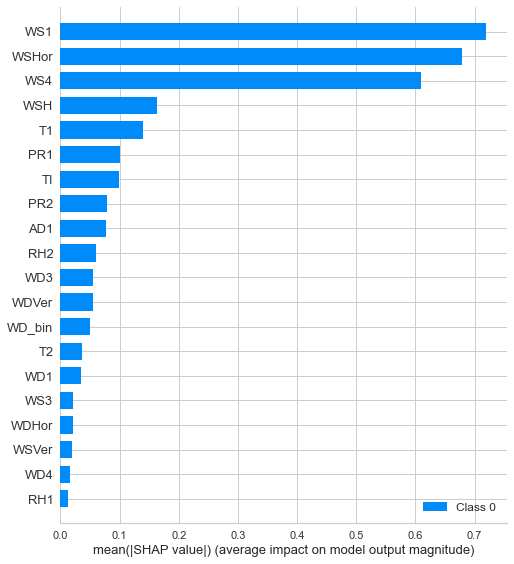

Feature importance through SHAP values performed


In [86]:
shap_values=feature_importance (X_train, X_test, model)

In [87]:
k=transform_shap (shap_values, X_test)

In [88]:
k

,variables,SHAP_abs
0,T2,0.036240
1,RH2,0.059350
2,T1,0.140195
3,RH1,0.013505
4,PR1,0.100791
5,AD1,0.076489
6,PR2,0.077937
7,AD2,0.008116
8,Rain,0.005398
9,WS1,0.718561
